In [10]:
import glob

import torch
import numpy as np
from scipy.io import loadmat
from scipy.signal import resample

from timedenoiser.models.cnn import ShallowCNN
from timedenoiser.models.encdec import *
from timedenoiser.models.unet import UNET_1D
from timedenoiser.models.ekf import ekf
from timedenoiser.models.tv1d import tv
from timedenoiser.models.wt import wt

from motormetrics.ml import *
from motormetrics.ee import *
from motormetrics.ee import get_ramp_from_sim_reference

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
model_id = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_iq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_ud = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_uq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')

# model_id = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_iq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_ud = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_uq = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

# model_id = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_iq = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_ud = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_uq = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.01_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_id.eval()
model_iq.eval()
model_ud.eval()
model_uq.eval()

model_spd = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_current_d,current_q,voltage_d,voltage_q_outQuants_speed_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
model_trq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_current_d,current_q,voltage_d,voltage_q_outQuants_torque_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_spd.eval()
model_trq.eval()

model_spd_n = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d,noisy_current_q,noisy_voltage_d,noisy_voltage_q_outQuants_speed_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
model_trq_n = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d,noisy_current_q,noisy_voltage_d,noisy_voltage_q_outQuants_torque_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_spd_n.eval()
model_trq_n.eval()

ShallowEncDec(
  (cnn1): Conv1d(4, 32, kernel_size=(10,), stride=(1,))
  (cnn2): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
  (cnn3): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (cnn4): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (dcnn4): ConvTranspose1d(256, 128, kernel_size=(3,), stride=(1,))
  (dcnn3): ConvTranspose1d(128, 64, kernel_size=(5,), stride=(1,))
  (dcnn2): ConvTranspose1d(64, 32, kernel_size=(7,), stride=(1,))
  (dcnn1): ConvTranspose1d(32, 1, kernel_size=(10,), stride=(1,))
  (act): ReLU()
)

In [12]:
class Exper():
        def __init__(self, kwargs):
            for k in kwargs:
                self.__dict__[k] = kwargs[k]
                
def compute_ml(data, speed_pred, torque_pred):
    ndata = {}
    for k in data.keys():
        if '__' not in k:
            ndata[k] = data[k][0]

    print ('Speed')
    print ('SMAPE :', smape(speed_pred, ndata['speed']))
    print ('R2 :', r2(speed_pred, ndata['speed']))
    print ('RMSE :', rmse(speed_pred, ndata['speed']))
    print ('MAE :', mae(speed_pred, ndata['speed']))

    print ('Torque')
    print ('SMAPE :', smape(torque_pred, ndata['torque']))
    print ('R2 :', r2(torque_pred, ndata['torque']))
    print ('RMSE :', rmse(torque_pred, ndata['torque']))
    print ('MAE :', mae(torque_pred, ndata['torque']))
    
def compute_ee(data, speed_pred, torque_pred):
    ndata = {}
    for k in data.keys():
        if '__' not in k:
            ndata[k] = data[k][0]

    ndata['speed'] = speed_pred
    ndata['torque'] = torque_pred
    model_exp = Exper(ndata)

    model_torque_metrics = compute_torque_metrics(model_exp)
    model_speed_metrics = compute_speed_metrics(model_exp)

    print (model_speed_metrics)
    print (model_torque_metrics)

In [13]:
mat_file = '../../../datasets/Data_27012021_noisy/benchmark/bench4.mat'

st = 0 
et = -1

data = loadmat(mat_file)

x_id = np.stack([data['noisy_current_d'][0] / 30]) 
x_iq = np.stack([data['noisy_current_q'][0] / 30])
x_ud = np.stack([data['noisy_voltage_d'][0] / 300]) 
x_uq = np.stack([data['noisy_voltage_q'][0] / 300])

x_c = np.stack([[x_id[0], x_iq[0], x_ud[0], x_uq[0]]])

x = np.stack([data['current_d'][0] / 30, 
                  data['current_q'][0] / 30,
                  data['voltage_d'][0] / 300,
                  data['voltage_q'][0] / 300])


inp_id = torch.tensor([x_id[:, st:et]]).cuda().float()
out_id = model_id(inp_id)
out_id_da = out_id.data.cpu().numpy()[0]
out_id_wt = wt(data['noisy_current_d'][0], 0.17)
out_id_ekf = ekf(data['noisy_current_d'][0], 0.17)
out_id_tv = tv(data['noisy_current_d'][0], 0.17)

inp_iq = torch.tensor([x_iq[:, st:et]]).cuda().float()
out_iq = model_iq(inp_iq)
out_iq_da = out_iq.data.cpu().numpy()[0]
out_iq_wt = wt(data['noisy_current_q'][0], 0.29)
out_iq_ekf = ekf(data['noisy_current_q'][0], 0.29)
out_iq_tv = tv(data['noisy_current_q'][0], 0.29)

inp_ud = torch.tensor([x_ud[:, st:et]]).cuda().float()
out_ud = model_ud(inp_ud)
out_ud_da = out_ud.data.cpu().numpy()[0]
out_ud_wt = wt(data['noisy_voltage_d'][0], 1.85)
out_ud_ekf = ekf(data['noisy_voltage_d'][0], 1.85)
out_ud_tv = tv(data['noisy_voltage_d'][0], 1.85)

inp_uq = torch.tensor([x_uq[:, st:et]]).cuda().float()
out_uq = model_uq(inp_uq)
out_uq_da = out_uq.data.cpu().numpy()[0]
out_uq_wt = wt(data['noisy_voltage_q'][0], 1.78)
out_uq_ekf = ekf(data['noisy_voltage_q'][0], 1.78)
out_uq_tv = tv(data['noisy_voltage_q'][0], 1.78)

inp = torch.tensor([x[:, st:et]]).cuda().float()
out_spd = model_spd(inp)
out_spd = out_spd.data.cpu().numpy()[0]

out_trq = model_trq(inp)
out_trq = out_trq.data.cpu().numpy()[0]

inps_da = torch.from_numpy(np.stack([[out_id_da[0], 
                                       out_iq_da[0], 
                                       out_ud_da[0], 
                                       out_uq_da[0]]])).cuda()
inps_wt = torch.from_numpy(np.stack([[out_id_wt / 30, 
                                       out_iq_wt / 30, 
                                       out_ud_wt / 300, 
                                       out_uq_wt / 300]])).cuda().float()
inps_ekf = torch.from_numpy(np.stack([[out_id_ekf / 30, 
                                       out_iq_ekf / 30, 
                                       out_ud_ekf / 300, 
                                       out_uq_ekf / 300]])).cuda().float()
inps_tv = torch.from_numpy(np.stack([[out_id_tv / 30, 
                                       out_iq_tv / 30, 
                                       out_ud_tv / 300, 
                                       out_uq_tv / 300]])).cuda().float()
inps_c = torch.from_numpy(x_c).cuda().float()

out_spd_da = model_spd(inps_da)
out_spd_da = out_spd_da.data.cpu().numpy()[0]
out_spd_wt = model_spd(inps_wt)
out_spd_wt = out_spd_wt.data.cpu().numpy()[0]
out_spd_ekf = model_spd(inps_ekf)
out_spd_ekf = out_spd_ekf.data.cpu().numpy()[0]
out_spd_tv = model_spd(inps_tv)
out_spd_tv = out_spd_tv.data.cpu().numpy()[0]
out_spd_b = model_spd_n(inps_c)
out_spd_b = out_spd_b.data.cpu().numpy()[0]
out_spd_c = model_spd(inps_c)
out_spd_c = out_spd_c.data.cpu().numpy()[0]

out_trq_da = model_trq(inps_da)
out_trq_da = out_trq_da.data.cpu().numpy()[0]
out_trq_wt = model_trq(inps_wt)
out_trq_wt = out_trq_wt.data.cpu().numpy()[0]
out_trq_ekf = model_trq(inps_ekf)
out_trq_ekf = out_trq_ekf.data.cpu().numpy()[0]
out_trq_tv = model_trq(inps_tv)
out_trq_tv = out_trq_tv.data.cpu().numpy()[0]
out_trq_b = model_trq(inps_c)
out_trq_b = out_trq_b.data.cpu().numpy()[0]
out_trq_c = model_trq_n(inps_c)
out_trq_c = out_trq_c.data.cpu().numpy()[0]



In [14]:

alpha = 0.1
speed_pred = np.copy(data['speed'][0])
speed_pred[:-1] = out_spd[0] * 80
speed_pred = alpha * speed_pred + (1 - alpha) * data['speed'][0]

torque_pred = np.copy(data['torque'][0])
torque_pred[:-1] = out_trq[0] * 120
torque_pred = alpha * torque_pred + (1 - alpha) * data['torque'][0]

alpha = 0.15
speed_pred_b = out_spd_b[0] * 80
speed_pred_b = alpha * speed_pred_b + (1 - alpha) * data['speed'][0]

torque_pred_b = out_trq_b[0] * 120
torque_pred_b = alpha * torque_pred_b + (1 - alpha) * data['torque'][0]

alpha = 0.14
speed_pred_c = out_spd_c[0] * 80
speed_pred_c = alpha * speed_pred_c + (1 - alpha) * data['speed'][0]

torque_pred_c = out_trq_c[0] * 120
torque_pred_c = alpha * torque_pred_c + (1 - alpha) * data['torque'][0]

alpha = 0.11
speed_pred_da = np.copy(data['speed'][0])
speed_pred_da[:-1] = out_spd_da[0] * 80
speed_pred_da = alpha * speed_pred_da + (1 - alpha) * data['speed'][0]

torque_pred_da = np.copy(data['torque'][0])
torque_pred_da[:-1] = out_trq_da[0] * 120
torque_pred_da = alpha * torque_pred_da + (1 - alpha) * data['torque'][0]

alpha = 0.14
speed_pred_wt = out_spd_wt[0] * 80
speed_pred_wt = alpha * speed_pred_wt + (1 - alpha) * data['speed'][0]

torque_pred_wt = out_trq_wt[0] * 120
torque_pred_wt = alpha * torque_pred_wt + (1 - alpha) * data['torque'][0]

alpha = 0.15
speed_pred_ekf = out_spd_ekf[0] * 80
speed_pred_ekf = alpha * speed_pred_ekf + (1 - alpha) * data['speed'][0]

torque_pred_ekf = out_trq_ekf[0] * 120
torque_pred_ekf = alpha * torque_pred_ekf + (1 - alpha) * data['torque'][0]

alpha = 0.12
speed_pred_tv = out_spd_tv[0] * 80
speed_pred_tv = alpha * speed_pred_tv + (1 - alpha) * data['speed'][0]

torque_pred_tv = out_trq_tv[0] * 120
torque_pred_tv = alpha * torque_pred_tv + (1 - alpha) * data['torque'][0]



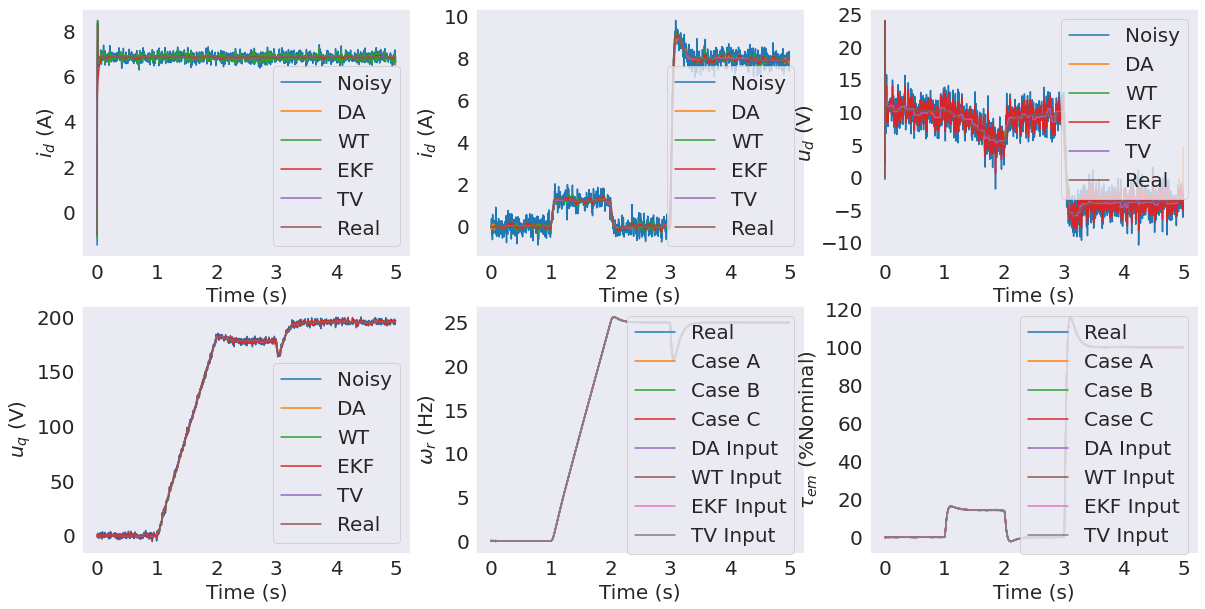

--------- Real -----------
{'perc2_times': [0.048], 'perc95_times': [0.948], 'following_errs': [-0.0095], 'following_times': [1.5], 'overshoot_errs': [2.5513], 'overshoot_times': [2.052], 'ramp_start_times': [1.0], 'sse_errs': [0.0012], 'sse_times': [2.8], 'max_trq_accs': [16.3422], 'max_trq_acc_times': [1.104]}
{'perc2_times': [0.008], 'perc95_times': [0.244], 'following_errs': [98.6784], 'following_times': [3.004], 'overshoot_errs': [15.9643], 'overshoot_times': [3.104], 'ramp_start_times': [3.0], 'sse_errs': [0.0082], 'sse_times': [4.8], 'speed_drops': [4.3945], 'speed_drops_times': [3.056]}
--------- Case A ----------
{'perc2_times': [0.048], 'perc95_times': [0.948], 'following_errs': [0.0032], 'following_times': [1.5], 'overshoot_errs': [2.474], 'overshoot_times': [2.06], 'ramp_start_times': [1.0], 'sse_errs': [-0.011], 'sse_times': [2.8], 'max_trq_accs': [16.4271], 'max_trq_acc_times': [1.108]}
{'perc2_times': [0.004], 'perc95_times': [0.244], 'following_errs': [96.8808], 'follow

In [15]:

sns.set_style("dark")
fig = plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.plot(data['time'][0, st:et], data['noisy_current_d'][0, st:et], label='Noisy')
plt.plot(data['time'][0, st:et], out_id_da[0] * 30, label='DA')
plt.plot(data['time'][0, st:et], out_id_wt[st:et], label='WT')
plt.plot(data['time'][0, st:et], out_id_ekf[st:et], label='EKF')
plt.plot(data['time'][0, st:et], out_id_tv[st:et], label='TV')
plt.plot(data['time'][0, st:et], data['current_d'][0, st:et], label='Real')
plt.ylabel(r'$i_d$ (A)', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.subplot(2, 3, 2)
plt.plot(data['time'][0, st:et], data['noisy_current_q'][0, st:et], label='Noisy')
plt.plot(data['time'][0, st:et], out_iq_da[0] * 30, label='DA')
plt.plot(data['time'][0, st:et], out_iq_wt[st:et], label='WT')
plt.plot(data['time'][0, st:et], out_iq_ekf[st:et], label='EKF')
plt.plot(data['time'][0, st:et], out_iq_tv[st:et], label='TV')
plt.plot(data['time'][0, st:et], data['current_q'][0, st:et], label='Real')
plt.ylabel(r'$i_d$ (A)', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.subplot(2, 3, 3)
plt.plot(data['time'][0, st:et], data['noisy_voltage_d'][0, st:et], label='Noisy')
plt.plot(data['time'][0, st:et], out_ud_da[0] * 300, label='DA')
plt.plot(data['time'][0, st:et], out_ud_wt[st:et], label='WT')
plt.plot(data['time'][0, st:et], out_ud_ekf[st:et], label='EKF')
plt.plot(data['time'][0, st:et], out_ud_tv[st:et], label='TV')
plt.plot(data['time'][0, st:et], data['voltage_d'][0, st:et], label='Real')
plt.ylabel(r'$u_d$ (V)', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.subplot(2, 3, 4)
plt.plot(data['time'][0, st:et], data['noisy_voltage_q'][0, st:et], label='Noisy')
plt.plot(data['time'][0, st:et], out_uq_da[0] * 300, label='DA')
plt.plot(data['time'][0, st:et], out_uq_wt[st:et], label='WT')
plt.plot(data['time'][0, st:et], out_uq_ekf[st:et], label='EKF')
plt.plot(data['time'][0, st:et], out_uq_tv[st:et], label='TV')
plt.plot(data['time'][0, st:et], data['voltage_q'][0, st:et], label='Real')
plt.ylabel(r'$u_q$ (V)', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.subplot(2, 3, 5)
plt.plot(data['time'][0, st:et], data['speed'][0, st:et], label='Real')
plt.plot(data['time'][0, st:et], speed_pred[st:et], label='Case A')
plt.plot(data['time'][0, st:et], speed_pred_b[st:et], label='Case B')
plt.plot(data['time'][0, st:et], speed_pred_c[st:et], label='Case C')
plt.plot(data['time'][0, st:et], speed_pred_da[st:et], label='DA Input')
plt.plot(data['time'][0, st:et], speed_pred_wt[st:et], label='WT Input')
plt.plot(data['time'][0, st:et], speed_pred_ekf[st:et], label='EKF Input')
plt.plot(data['time'][0, st:et], speed_pred_tv[st:et], label='TV Input')
plt.ylabel(r'$\omega_r$ (Hz)', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.subplot(2, 3, 6)
plt.plot(data['time'][0, st:et], data['torque'][0, st:et], label='Real')
plt.plot(data['time'][0, st:et], torque_pred[st:et], label='Case A')
plt.plot(data['time'][0, st:et], torque_pred_b[st:et], label='Case B')
plt.plot(data['time'][0, st:et], torque_pred_c[st:et], label='Case C')
plt.plot(data['time'][0, st:et], torque_pred_da[st:et], label='DA Input')
plt.plot(data['time'][0, st:et], torque_pred_wt[st:et], label='WT Input')
plt.plot(data['time'][0, st:et], torque_pred_ekf[st:et], label='EKF Input')
plt.plot(data['time'][0, st:et], torque_pred_tv[st:et], label='TV Input')
plt.ylabel(r'$\tau_{em}$ (%Nominal)', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.show()

print ('--------- Real -----------')
compute_ee(data, data['speed'][0], data['torque'][0])

print ('--------- Case A ----------')
compute_ee(data, speed_pred, torque_pred)
# compute_ml(data, speed_pred, torque_pred)
print ('Speed MAE', mae(speed_pred[st:et], data['speed'][0, st:et]))
print ('Torque MAE', mae(torque_pred[st:et], data['torque'][0, st:et]))
print ('Speed SMAPE', smape(speed_pred[st:et], data['speed'][0, st:et]))
print ('Torque SMAPE', smape(torque_pred[st:et], data['torque'][0, st:et]))

print ('--------- Case B ----------')
compute_ee(data, speed_pred_b, torque_pred_b)
# compute_ml(data, speed_pred_b, torque_pred_b)
print ('Speed MAE', mae(speed_pred_b[st:et], data['speed'][0, st:et]))
print ('Torque MAE', mae(torque_pred_b[st:et], data['torque'][0, st:et]))
print ('Speed SMAPE', smape(speed_pred_b[st:et], data['speed'][0, st:et]))
print ('Torque SMAPE', smape(torque_pred_b[st:et], data['torque'][0, st:et]))

print ('--------- Case C ----------')
compute_ee(data, speed_pred_c, torque_pred_c)
# compute_ml(data, speed_pred_c, torque_pred_c)
print ('Speed MAE', mae(speed_pred_c[st:et], data['speed'][0, st:et]))
print ('Torque MAE', mae(torque_pred_c[st:et], data['torque'][0, st:et]))
print ('Speed SMAPE', smape(speed_pred_c[st:et], data['speed'][0, st:et]))
print ('Torque SMAPE', smape(torque_pred_c[st:et], data['torque'][0, st:et]))

print ('------- DA --------')
compute_ee(data, speed_pred_da, torque_pred_da)
# compute_ml(data, speed_pred_da, torque_pred_da)
print ('Speed MAE', mae(speed_pred_ekf[st:et], data['speed'][0, st:et]))
print ('Torque MAE', mae(torque_pred_ekf[st:et], data['torque'][0, st:et]))
print ('Speed SMAPE', smape(speed_pred_ekf[st:et], data['speed'][0, st:et]))
print ('Torque SMAPE', smape(torque_pred_ekf[st:et], data['torque'][0, st:et]))

print ('------- WT --------')
compute_ee(data, speed_pred_wt, torque_pred_wt)
# compute_ml(data, speed_pred_wt, torque_pred_wt)
print ('Speed MAE', mae(speed_pred_wt[st:et], data['speed'][0, st:et]))
print ('Torque MAE', mae(torque_pred_wt[st:et], data['torque'][0, st:et]))
print ('Speed SMAPE', smape(speed_pred_wt[st:et], data['speed'][0, st:et]))
print ('Torque SMAPE', smape(torque_pred_wt[st:et], data['torque'][0, st:et]))

print ('------- EKF --------')
compute_ee(data, speed_pred_ekf, torque_pred_ekf)
# compute_ml(data, speed_pred_ekf, torque_pred_ekf)
print ('Speed MAE', mae(speed_pred_da[st:et], data['speed'][0, st:et]))
print ('Torque MAE', mae(torque_pred_da[st:et], data['torque'][0, st:et]))
print ('Speed SMAPE', smape(speed_pred_da[st:et], data['speed'][0, st:et]))
print ('Torque SMAPE', smape(torque_pred_da[st:et], data['torque'][0, st:et]))

print ('------- TV --------')
compute_ee(data, speed_pred_tv, torque_pred_tv)
# compute_ml(data, speed_pred_tv, torque_pred_tv)
print ('Speed MAE', mae(speed_pred_tv[st:et], data['speed'][0, st:et]))
print ('Torque MAE', mae(torque_pred_tv[st:et], data['torque'][0, st:et]))
print ('Speed SMAPE', smape(speed_pred_tv[st:et], data['speed'][0, st:et]))
print ('Torque SMAPE', smape(torque_pred_tv[st:et], data['torque'][0, st:et]))

In [17]:

st = int(2.5 / 0.004)
et = int(4 / 0.004)
sns.set_style("darkgrid")
plt.plot(data['time'][0, st:et], data['noisy_current_d'][0, st:et], 'g', label="Noisy", alpha=0.3)
plt.plot(data['time'][0, st:et], data['current_d'][0, st:et], 'k', label="Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data['time'][0, st:et], (0.5 * out_id_da[0][st:et] * 30 + 0.5 * out_id_tv[st:et]), 'r', label="MD", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$i_d$ (A)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('bench4_id.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data['time'][0, st:et], data['noisy_current_q'][0, st:et], 'g', label="Noisy", alpha=0.3)
plt.plot(data['time'][0, st:et], data['current_q'][0, st:et], 'k', label="Real")
# plt.plot(data['time'][0, st:et], out_iq_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_iq_tv[st:et], 'yellow', label="TV", alpha=0.5)
plt.plot(data['time'][0, st:et], (0.5 * out_iq_da[0][st:et] * 30 + 0.5 * out_iq_tv[st:et]), 'r', label="MD", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$i_q$ (A)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('bench4_iq.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data['time'][0, st:et], data['noisy_voltage_d'][0, st:et], 'g', label="Noisy", alpha=0.3)
plt.plot(data['time'][0, st:et], data['voltage_d'][0, st:et], 'k', label="Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data['time'][0, st:et], (0.5 * out_ud_da[0][st:et] * 300 + 0.5 * out_ud_tv[st:et]), 'r', label="MD", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$u_d$ (V)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
# plt.show()
plt.savefig('bench4_ud.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data['time'][0, st:et], data['noisy_voltage_q'][0, st:et], 'g', label="Noisy", alpha=0.3)
plt.plot(data['time'][0, st:et], data['voltage_q'][0, st:et], 'k', label="Real")
# plt.plot(data['time'][0, st:et], out_iq_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_iq_tv[st:et], 'yellow', label="TV", alpha=0.5)
plt.plot(data['time'][0, st:et], (0.5 * out_uq_da[0][st:et] * 300 + 0.5 * out_uq_tv[st:et]), 'r', label="MD", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$u_q$ (V)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('bench4_uq.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data['time'][0, st:et], data['reference_speed_interp'][0, st:et], 'g', label="Ref", alpha=0.3)
plt.plot(data['time'][0, st:et], data['speed'][0, st:et], 'k', label="Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data['time'][0, st:et], speed_pred[st:et], 'brown', label="DiagBiRNN Case A", alpha=1)
plt.plot(data['time'][0, st:et], speed_pred_c[st:et], 'y', label="DiagBiRNN Case C", alpha=1)
plt.plot(data['time'][0, st:et], speed_pred_da[st:et], 'r', label="MD + DiagBiRNN", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\omega_r$ (Hz)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('bench4_spd.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

sns.set_style("darkgrid")
plt.plot(data['time'][0, st:et], data['reference_torque_interp'][0, st:et], 'g', label="Ref", alpha=0.3)
plt.plot(data['time'][0, st:et], data['torque'][0, st:et], 'k', label="Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data['time'][0, st:et], torque_pred[st:et], 'brown', label="DiagBiRNN Case A", alpha=1)
plt.plot(data['time'][0, st:et], torque_pred_c[st:et], 'y', label="DiagBiRNN Case C", alpha=1)
plt.plot(data['time'][0, st:et], torque_pred_da[st:et], 'r', label="MD + DiagBiRNN", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\tau_{em}$ (%Nom)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('bench4_trq.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

st = int(2.8 / 0.004)
et = int(3.008 / 0.004)

sns.set_style("darkgrid")
plt.plot(data['time'][0, st:et], data['reference_torque_interp'][0, st:et], 'g', label="Ref", alpha=0.3)
plt.plot(data['time'][0, st:et], data['torque'][0, st:et], 'k', label="Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'red', label="TV", alpha=0.5)
plt.plot(data['time'][0, st:et], torque_pred[st:et], 'brown', label="DiagBiRNN Case A", alpha=1)
plt.plot(data['time'][0, st:et], torque_pred_c[st:et], 'y', label="DiagBiRNN Case C", alpha=1)
plt.plot(data['time'][0, st:et], torque_pred_da[st:et], 'r', label="MD + DiagBiRNN", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\tau_{em}$ (%Nom)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('bench4_trq_p1.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
plt.close()

st = int(3.004 / 0.004)
et = int(3.5 / 0.004)

sns.set_style("darkgrid")
plt.plot(data['time'][0, st:et], data['reference_torque_interp'][0, st:et], 'g', label="Ref", alpha=0.3)
plt.plot(data['time'][0, st:et], data['torque'][0, st:et], 'k', label="Real")
# plt.plot(data['time'][0, st:et], out_id_ekf[st:et], 'y', label="EKF")
# plt.plot(data['time'][0, st:et], out_id_tv[st:et], 'yellow', label="TV", alpha=0.5)
plt.plot(data['time'][0, st:et], torque_pred[st:et], 'brown', label="DiagBiRNN Case A", alpha=1)
plt.plot(data['time'][0, st:et], torque_pred_c[st:et], 'y', label="DiagBiRNN Case C", alpha=1)
plt.plot(data['time'][0, st:et], torque_pred_da[st:et], 'r', label="MD + DiagBiRNN", alpha=1)

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\tau_{em}$ (%Nom)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot()
# plt.show()
plt.savefig('bench4_trq_p2.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
# plt.close()
plt.close()